## Dacon - 퇴근시간 버스 승차 인원 예측 3등 코드 리뷰 + 개인 생각
### (Jeju Island Bus Passengers Estimation in Leaving work time)
- 같이 첨부된 pdf 파일에 대한 저작권은 전적으로 위 링크 3등팀에 있습니다.

### 목적 
- **<U> 18시부터 20시까지의 역별 버스 승차인원</U> 구하기 **   

### 데이터 설명
#### train, test  공통 사항
- 해당 데이터에는 버스카드를 통해 결제를 한 경우에 대한 정류소 승, 하차 데이터로 모든 승차정보의 경우는 기록이 되어있지만,
- 버스에서 하차를 할 때, 버스카드를 찍지 않는 경우, 해당 기록이 비어 있는 상태입니다. 따라서, 승차 인원수와 하차 인원수가 동일하지 않고 다소 차이가 있음을 미리 알려드립니다.

#### train, test csv 공통사항
- 해당 버스정류장에 대한 각각의 위도, 경도가 제공이 되어있는 상태로 같은 정류장 이름이지만 위도와 경도가 서로 다른 경우가 존재합니다. 
- 해당 경우는, 같은 정류장 이름을 가지고 있는 길 건너편의 정류장에 해당이 됩니다.

#### train.csv and test.csv
- train.csv 의 경우, <U>**2019년 9월 제주도의 각 날짜, 출근시간 (6시~12시)의 버스 정류장별 승하차 인원**</U>,  <U>**퇴근시간(18시~20시)의 버스 정류장별 승차 인원**</U>이 기록되어 있습니다.
- test.csv의 경우, <U>**2019년 10월의 각 날짜, 출근시간(오전 6시~12시)의 버스 정류장별 승하차 인원**</U>이 기록되어  있음.

#### submission_제출양식.csv 
- submission_제출양식의 경우, test data의 ID와 목표변수인 18시~20시 승차 인원로만 이루어져 있습니다.
- 참가자분들께서는 test.csv에서 ID와 예측값을 결합하여, 해당 submission_제출양식.csv 파일형식 처럼 만든 이후,
- 해당 제출 파일 양식 그대로(변수명 포함된 상태) 제출을 해주시면 됩니다

### 변수 설명
- id(고유번호=인덱스), date(날짜), bus_route_id(버스경로 id)
- in_out(시내버스, 시외버스), station_code(정거장 번호 id)
- station_name(정거장 이름), latitude(위도), longitude(경도)
- 6-7_ride, 7-8_ride, 9-10_ride, 10-11_ride, 11-12_ride (오전시간 탑승인원)
- 6-7_takeoff, 7-8_takeoff, 9-10_takeoff, 10-11_takeoff, 11-12_takeoff (오전시간 하차 인원)
- 18-20_ride (퇴근시간 탑승인원)

### EDA Idea
- 변수 섞어서 쓴 이유
- BUS_ROUTE_ID / VHC_ID  -> GROUP BY 분석 용이하게 위해서, / 혹은 교호작용? 좀더 작게도보고 크게도 보고
- 위경도 처리시 위경도 이상치도 포함? (특수한 경우(이상치가 그 특성상 맞는것이다)가 발생하기 힘들고 gps 는 명확한거니까!!!!)

### 1. Cleaning
- Bus route id 0000 제거해서 변수 하나 만듬
- Station name 띄어쓰기 제거
- 위도, 경도 round 해서 사용
- ==> 지역성을 띄게 하기 위한?

### 2. Combine
- Bus route id + station code
- Bus route id + 위도, 경도 정보

### 3. Outlier remove
- Train, test data 두개의 데이터 셋에 모두 존재하는 데이터 사용

### 4. Agg Feature
- Day 기준, 평균/80백분위수 데이터로 집계함수 사용
- Day 기준, (bus route id, station code, station name) 평균/80백분위수 데이터로 집계함수 사용

### 5. Frequency encoding
- Bus route id, station code, station name 등의 Categorical 변수의 경우 빈도수를 계산해 줌으로써 모델에 다양한 정보를 주었음.

In [124]:
# Library 예시
import os

# handling
import pandas as pd
import numpy as np
import datetime
import random
import gc # garbage collector 라이브러리. 해당 gc 모듈은 오로지 순환 참조를 탐지하고 해결하기 위해 존재

#  for문의 상태바를 나타내주는 tqdm라이브러리 (for문의 print문 외에 진행바로 사용가능.)
from tqdm import tqdm_notebook as tqdm

import os
os.chdir("C:\\Users\\urse\\Desktop\\dataset\\Dacon-BusJeju")

In [126]:
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# prevent overfit
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import lightgbm as lgb

SEED=42
def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

def rmse(y_true, y_pred):
    return np.round(np.sqrt(mean_squared_error(y_true, y_pred)), 5)

########################### BASIC SETTING
retval = os.getcwd() #사용자가 불러온거 처리하기 위해서 임시로만 생성한 것
os.chdir(retval)
seed_everything(SEED)
TARGET = '18~20_ride'

In [127]:
# 1. 데이터 로드
########################### DATA LOAD
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sub = pd.read_csv('submission_sample.csv')

In [128]:
# 1.1 데이터 확인
print(train_df.shape)
train_df.head()

(415423, 21)


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,2019-09-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,4.0,...,2.0,5.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,2,2019-09-01,4270000,시외,432,정존마을,33.48181,126.47352,1.0,1.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,3,2019-09-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,0.0,17.0,...,26.0,14.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,53.0
4,4,2019-09-01,4270000,시내,1646,중문관광단지입구,33.25579,126.41260,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [129]:
print(test_df.shape)
test_df.head()

(228170, 20)


,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.48990,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,415424,2019-10-01,4270000,시외,357,한라병원,33.48944,126.48508,1.0,6.0,6.0,1.0,8.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0
2,415425,2019-10-01,4270000,시외,432,정존마을,33.48181,126.47352,2.0,4.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,415426,2019-10-01,4270000,시내,1579,제주국제공항(600번),33.50577,126.49252,1.0,11.0,18.0,8.0,26.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0
4,415427,2019-10-01,4270000,시내,1636,롯데호텔,33.24872,126.41032,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [130]:
# 복사해주는 함수 생성
def df_copy(tr_df, te_df):
    tr = tr_df.copy()
    te = te_df.copy()
    return tr, te

In [131]:
from sklearn.preprocessing import LabelEncoder

# 데이터 전처리 (Cleansing & Pre-Processing)
def base_preprocessing(tr_df, te_df):
    tr, te = df_copy(tr_df, te_df)
    # 4270000 -> 427로? 
    tr['bus_route_id'] = tr['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    te['bus_route_id'] = te['bus_route_id'].apply(lambda x: str(x)[:-4]).astype(int)
    
    # 데이터 전처리 2 - 지역 이름 변수 만들기
    tr['station_name2'] = tr['station_name'].apply(lambda x: str(x)[:2])
    te['station_name2'] = te['station_name'].apply(lambda x: str(x)[:2])

    # 데이터 전처리 3 - station name 공백 지우기 (띄어쓰기 제거)
    tr['station_name'] = tr['station_name'].apply(lambda x: x.replace(' ', ''))
    te['station_name'] = te['station_name'].apply(lambda x: x.replace(' ', ''))
    
    # 데이터 전처리 4 - label encoder / station_name, station_name2 Label Encoder 변환
    le = LabelEncoder().fit(pd.concat([tr['station_name'], te['station_name']]))
    le2 = LabelEncoder().fit(pd.concat([tr['station_name2'], te['station_name2']]))
    
    for df in [tr, te]:
    # 데이터 전처리 5 - day(날짜), week(주), weekday (요일)
        df['day'] = pd.to_datetime(df['date']).dt.day
        df['week'] = pd.to_datetime(df['date']).dt.week
        df['weekday'] = pd.to_datetime(df['date']).dt.weekday

    # 데이터 전처리 4 - label encoder / station_name, station_name2 Label Encoder 변환
        df['station_name'] = le.transform(df['station_name'])
        df['station_name2'] = le2.transform(df['station_name2'])
    
    # 데이터 전처리 6 - 승차시간, 퇴근시간 변수 만들기
    # 승차시간 2시간, 3시간, 4시간 
    # 퇴근시간 2시간, 3시간, 4시간
        df['6~8_ride'] = df[['6~7_ride','7~8_ride']].sum(1)
        df['6~9_ride'] = df[['6~7_ride','7~8_ride','8~9_ride']].sum(1)
        df['6~10_ride'] = df[['6~7_ride','7~8_ride','8~9_ride', '9~10_ride']].sum(1)
        
        df['6~8_takeoff'] = df[['6~7_takeoff','7~8_takeoff']].sum(1)
        df['6~9_takeoff'] = df[['6~7_takeoff','7~8_takeoff','8~9_takeoff']].sum(1)
        df['6~10_takeoff'] = df[['6~7_takeoff','7~8_takeoff','8~9_takeoff', '9~10_takeoff']].sum(1)
    
    # test_set day 30더하기???
    te['day'] = te['day']+30 # 9월 10월을 구분하기 위해서
    return tr, te

In [132]:
# 위도, 경도 round 해서 사용하기
def lat_long_create(tr_df, te_df):
    tr, te = df_copy(tr_df, te_df)
    # 위경도 소수점 2째자리 까지만
    tr['lat_long'] = np.round(tr['latitude'], 2).astype(str) + np.round(tr['longitude'], 2).astype(str)
    te['lat_long'] = np.round(te['latitude'], 2).astype(str) + np.round(te['longitude'], 2).astype(str)

    # 원핫인코딩 변환
    le = LabelEncoder().fit(pd.concat([tr['lat_long'], te['lat_long']]))
    tr['station_lat_long'] = le.transform(tr['lat_long'])
    te['station_lat_long'] = le.transform(te['lat_long'])

    # 위경도 소수점 3째자리 까지만 넣음
    tr['lat_long'] = np.round(tr['latitude'], 3).astype(str) + np.round(tr['longitude'], 2).astype(str)
    te['lat_long'] = np.round(te['latitude'], 3).astype(str) + np.round(te['longitude'], 2).astype(str)
    le = LabelEncoder().fit(pd.concat([tr['lat_long'], te['lat_long']]))
    tr['station_lat_long2'] = le.transform(tr['lat_long'])
    te['station_lat_long2'] = le.transform(te['lat_long'])
    return tr, te

33.20835 33.963640000000005
126.16504 126.96567
count    415423.000000
mean         33.420375
std           0.107996
min          33.208350
25%          33.291080
50%          33.478850
75%          33.500020
max          33.963640
Name: latitude, dtype: float64


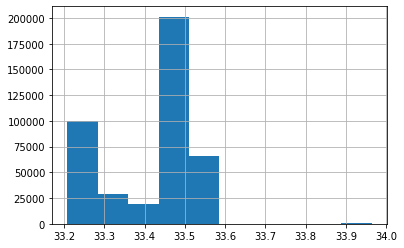

In [133]:
# 개인 의견 - 위경도 이상치 제거 필요?!
# min, max 찍어보니까 둘다 33. 126. 이긴 함 -> 다 그 부분부분으로 셀처럼 묶음으로서 
# ex) 그 부근으로 가는건 오래걸리는구나 뭐 요런느낌?

print(train_df['latitude'].min(), train_df['latitude'].max())
print(train_df['longitude'].min(), train_df['longitude'].max())
print(train_df['latitude'].describe())
train_df['latitude'].hist()

In [134]:
# 개인 의견 - 위경도 이상치 제거 필요?!
# 위경도 33.7이상 벗어나는 건 아마 이상치가 아닌가 생각

# (구글 맵에 찍어본 사진 비교)
ts = train_df.loc[train_df['latitude']>=33.57]
print(ts.shape)
ts['latitude']


(375, 21)


81        33.96269
82        33.96364
83        33.96284
84        33.96232
85        33.96141
            ...   
399639    33.94379
399640    33.94093
399641    33.94468
399642    33.94794
399643    33.96046
Name: latitude, Length: 375, dtype: float64

![위경도이상치33.96_126.49](./img/위경도이상치33.96_126.49.PNG)
![위경도이상치33.57_126.73](./img/위경도이상치33.57_126.73.PNG)


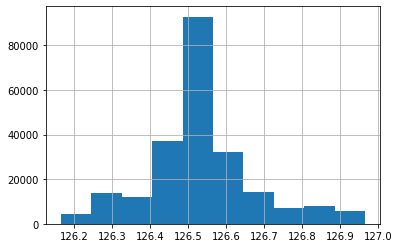

In [135]:
# 개인 의견 - 위경도 이상치 제거 필요?!
# 경도에 대한 이상치는 없음
test_df['longitude'].hist()

In [136]:
# 변수들 결합 - 버스노선 ID와 Station code에 대해 묶은 후 카테고리 형으로 변환
def feature_combine(tr_df, te_df):
    tr, te = df_copy(tr_df, te_df)
    for df in [tr, te]:
        df['bus_route_id_station_code'] = ((df['bus_route_id']).astype(str) 
                                           + (df['station_code']).astype(str)).astype('category')
        df['bus_route_id_station_lat_long'] = ((df['bus_route_id']).astype(str) 
                                               + (df['station_lat_long']).astype(str)).astype('category')
    return tr, te


#####################
# category 형 -> 행단위로 추가할시 나중에 들어온 값들이 낮은 값이다?
# category 형 -> value_counts() 를 통해서 값 x 각 구간에 따른 성분의 갯수를 확인했었으면, 
# 카테고리 자료형에서는 각 구간에 속한 성분의 갯수도 파악할 수 있다. (cut 함수)
#####################

# 특정 컬럼들 category 형으로 변환
def category_transform(tr_df, te_df, columns):
    tr, te = df_copy(tr_df, te_df)
    
    # train data와 test data의 해당 column들을 category로 변환
    for df in [tr, te]:
        df[columns] = df[columns].astype(str).astype('category') # category라고 하면 get_dummies없이 바로 모델에 넣을수 있나봄.
    return tr, te

In [137]:
# Frequency encoding
# - Bus route id, station code, station name 등의
# Categorical 변수의 경우 빈도수를 계산해 줌으로써 모델에 다양한 정보를 주었음
# 각 컬럼들의 항목 빈도수를 매핑해서 넣음 -> 28200이 1032개이면 28200 행의 새로운 열에 1032라고 적음

def frequency_encoding(tr_df, te_df, columns, normalize=False):
    tr, te = df_copy(tr_df, te_df)
    
    for col in columns:
        
        # Normalize 가 False 가 아닐 때
        if not normalize:
            freq_encode = pd.concat([tr[col], te[col]]).value_counts()
            tr[col+'_fq_enc'] = tr[col].map(freq_encode)
            te[col+'_fq_enc'] = te[col].map(freq_encode)
        # Normalize가 False 일 때
        else:
            freq_encode = pd.concat([tr[col], te[col]]).value_counts(normalize=True)
            tr[col+'_fq_enc_nor'] = tr[col].map(freq_encode)
            te[col+'_fq_enc_nor'] = te[col].map(freq_encode)
    return tr, te

In [138]:
# train과 test 에 서로 다 존재하는 것들만 사용.
# -> 너무 성능위주적인?  / -> 좀 말이 안됨.
def remove_outlier(tr_df, te_df, columns):
    tr, te = df_copy(tr_df, te_df)
    for col in columns:
        tr[col] = np.where(tr[col].isin(te[col]), tr[col], 0) # np.where (조건문만족하면 , 여기실행, 아니면여기실행)
        te[col] = np.where(te[col].isin(tr[col]), te[col], 0)
    return tr, te


In [139]:
# Agg Feature
# Day 기준, 평균 / 80백분위수 데이터로 집계함수 사용
# Day 기준, (bus_route_id, station code, station_name) 평균/80백분위수 데이터로 집계함수 사용
# day 기준 ride_take란 변수로 다 묶어버리고, / 
def day_agg(tr_df, te_df, merge_columns, columns, aggs=['mean']):
    # 데이터 복사
    tr, te = df_copy(tr_df, te_df)
    
    for merge_column in merge_columns:
        for col in columns:
            for agg in aggs:
                valid = pd.concat([tr[[merge_column, col]], te[[merge_column, col]]])
                new_cn = merge_column + '_' + agg + '_' + col # 새로운 column들
                if agg=='quantile': 
                    valid = valid.groupby(merge_column)[col].quantile(0.8).reset_index().rename(columns={col:new_cn})
                else:
                    valid = valid.groupby(merge_column)[col].agg([agg]).reset_index().rename(columns={agg:new_cn})
                valid.index = valid[merge_column].tolist()
                valid = valid[new_cn].to_dict()
            
                tr[new_cn] = tr[merge_column].map(valid)
                te[new_cn] = te[merge_column].map(valid)
    return tr, te

# sub day  -> mean, quantile 여기서 진행
def sub_day_agg(tr_df, te_df, merge_columns, date_columns, columns, aggs=['mean']):
    tr, te = df_copy(tr_df, te_df)
    for merge_column in merge_columns:
        for date in date_columns:
            tr['mc_date'] = tr[merge_column].astype(str) + '_' +tr[date].astype(str)
            te['mc_date'] = te[merge_column].astype(str) + '_' +te[date].astype(str)
            for col in columns:
                for agg in aggs:
                    valid = pd.concat([tr[['mc_date', col]], te[['mc_date', col]]])
                    new_cn = merge_column + '_' + date + '_' + col + '_' + agg # 새로운 column 들
                    
                    if agg=='quantile':
                        valid = valid.groupby('mc_date')[col].quantile(0.8).reset_index().rename(columns={col:new_cn})
                    else:
                        valid = valid.groupby('mc_date')[col].agg([agg]).reset_index().rename(columns={agg:new_cn})
                    valid.index = valid['mc_date'].tolist()
                    valid = valid[new_cn].to_dict() # valid가 dataframe 고 map으로 넣어주면 가능 ! (싱기)
                
                    tr[new_cn] = tr['mc_date'].map(valid)
                    te[new_cn] = te['mc_date'].map(valid)
    tr = tr.drop(columns=['mc_date'])
    te = te.drop(columns=['mc_date'])
    return tr, te

In [140]:
########################### Final features list
remove_features = ['id', 'date', 'in_out', TARGET]
ride_take = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff']

remove_features += ['day', 'week', 'weekday', 'lat_long'] 
# day랑 weekday같은경우는 train과 test값들이 서로 같지가 않음
# 학습에서는 그러면 지워주는게 맞음. ex) 9월 1~30 10월 1~30 ==> 요일같은경우는 공통으로 묶을 수 있으나, 
# 즉 일별 트렌드가 존재한다 (==> 1년 정도의 데이터를 보고 일단위로 원핫인코더 가능)

tr, te = base_preprocessing(train_df, test_df)
tr, te = lat_long_create(tr, te)
tr, te = feature_combine(tr, te)

ride_take += ['6~8_ride', '6~9_ride', '6~10_ride', '6~8_takeoff', '6~9_takeoff', '6~10_takeoff']

In [141]:
tr, te = day_agg(tr, te, merge_columns=['day'], columns=ride_take, aggs=['mean'])
tr, te = sub_day_agg(tr, te, merge_columns=['bus_route_id', 'station_code', 'station_lat_long'], date_columns=['day'], columns=ride_take, aggs=['mean'])
tr, te = sub_day_agg(tr, te, merge_columns=['bus_route_id', 'station_code', 'station_name', 'station_lat_long'], date_columns=['day'], columns=ride_take, aggs=['quantile'])

In [142]:
category_features = ['bus_route_id', 'station_code', 'station_name', 'station_name2', 'station_lat_long', 'station_lat_long2', 'bus_route_id_station_code', 'bus_route_id_station_lat_long']
# 크기에 대한 경향성을 보여주는 느낌?
tr, te = frequency_encoding(tr, te, category_features) # 빈도수 계산해서 넣기.

In [144]:
tr.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,station_lat_long_day_6~9_takeoff_quantile,station_lat_long_day_6~10_takeoff_quantile,bus_route_id_fq_enc,station_code_fq_enc,station_name_fq_enc,station_name2_fq_enc,station_lat_long_fq_enc,station_lat_long2_fq_enc,bus_route_id_station_code_fq_enc,bus_route_id_station_lat_long_fq_enc
0,0,2019-09-01,427,시외,344,1489,33.48990,126.49373,0.0,1.0,...,2.0,3.0,1189,46,86,73327,16812,7037,46,138
1,1,2019-09-01,427,시외,357,1831,33.48944,126.48508,1.0,4.0,...,2.0,3.0,1189,2303,4756,8412,16812,2303,46,138
2,2,2019-09-01,427,시외,432,1413,33.48181,126.47352,1.0,1.0,...,1.0,1.0,1189,1154,2426,2426,5376,1774,46,46
3,3,2019-09-01,427,시내,1579,1438,33.50577,126.49252,0.0,17.0,...,17.4,21.0,1189,49,49,73327,3501,2378,46,50
4,4,2019-09-01,427,시내,1646,1583,33.25579,126.41260,0.0,0.0,...,1.0,1.0,1189,386,826,8830,1290,896,39,39


In [143]:
te.head()

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,station_lat_long_day_6~9_takeoff_quantile,station_lat_long_day_6~10_takeoff_quantile,bus_route_id_fq_enc,station_code_fq_enc,station_name_fq_enc,station_name2_fq_enc,station_lat_long_fq_enc,station_lat_long2_fq_enc,bus_route_id_station_code_fq_enc,bus_route_id_station_lat_long_fq_enc
0,415423,2019-10-01,427,시외,344,1489,33.48990,126.49373,4.0,4.0,...,2.0,3.0,1189,46,86,73327,16812,7037,46,138
1,415424,2019-10-01,427,시외,357,1831,33.48944,126.48508,1.0,6.0,...,2.0,3.0,1189,2303,4756,8412,16812,2303,46,138
2,415425,2019-10-01,427,시외,432,1413,33.48181,126.47352,2.0,4.0,...,1.0,2.0,1189,1154,2426,2426,5376,1774,46,46
3,415426,2019-10-01,427,시내,1579,1438,33.50577,126.49252,1.0,11.0,...,19.4,26.0,1189,49,49,73327,3501,2378,46,50
4,415427,2019-10-01,427,시내,1636,480,33.24872,126.41032,0.0,0.0,...,2.0,2.4,1189,77,77,1011,2054,357,31,316


In [145]:
# 2. 변수 선택 및 모델 구축 및 학습
# Feature Engineering & Initial Modeling
# Kfold를 이용한 out of folds 이용
# StartifieldKFold 이요
# 앙상블
os.chdir(retval)
########################### Model
def make_predictions(model, tr_df, tt_df, features_columns, target, params, category_feature=[''], NFOLDS=4, oof_save=False, clip=999, SEED=SEED):
    X,y = tr_df[features_columns], tr_df[target]
    kf = KFold(n_splits=NFOLDS, shuffle=True, random_state=SEED)

    oof = np.zeros(len(tr_df))
    pred = np.zeros(len(tt_df))
    fi_df = pd.DataFrame()
    
    for fold_, (trn_idx, val_idx) in enumerate(kf.split(X)):
        print('Fold:',fold_)
        tr_data = lgb.Dataset(X.loc[trn_idx], label=y[trn_idx].clip(0, clip)) # np.clip(a, 0, 4) # 0보다 작은 값 다 일정값으로 변환
        vl_data = lgb.Dataset(X.loc[val_idx], label=y[val_idx])
        if model=='lgb':
            estimator = lgb.train(params, tr_data, valid_sets = [tr_data, vl_data], verbose_eval = 500)
            fi_df = pd.concat([fi_df, pd.DataFrame(sorted(zip(estimator.feature_importance(), features_columns)), columns=['Value', 'Feature'])])
        
        oof[val_idx] = estimator.predict(X.loc[val_idx])
        pred += estimator.predict(tt_df[features_columns])/NFOLDS
        del estimator
        gc.collect()

    oof = np.where(oof>0, oof, 0)
    pred = np.where(pred>0, pred, 0)

    if oof_save:
        if model=='lgb':
            np.save(retval+'\\content\\oof_lgb.npy', oof)
            np.save(retval+'\\content\\pred_lgb.npy', pred)
        elif model=='cat':
            np.save(retval+'\\content\\oof_cat.npy', oof)
            np.save(retval+'\\content\\pred_cat.npy', pred)

    tt_df[target] = pred
    print('OOF RMSE:', rmse(y, oof))
    
    try:
        fi_df = fi_df.groupby('Feature').mean().reset_index().sort_values('Value')
    except:
        pass

    return tt_df[['id', target]], fi_df
## -------------------

In [148]:
lgb_params = {
        'objective':'regression',
        'boosting_type':'gbdt',
        'metric':'rmse',
        'n_jobs':-1,
        'learning_rate':0.003,
        'num_leaves': 700,
        'max_depth':-1,
        'min_child_weight':5,
        'colsample_bytree': 0.3,
        'subsample':0.7,
        'n_estimators':10, # 50000
        'gamma':0,
        'reg_lambda':0.05,
        'reg_alpha':0.05,
        'verbose':-1,
        'seed': SEED,
        'early_stopping_rounds': 5 #50
    }
tr, te = remove_outlier(tr, te, category_features)
tr, te = category_transform(tr, te, category_features)

features_columns = [col for col in tr.columns if col not in remove_features]

In [149]:
test_predictions, fi = make_predictions('lgb', tr, te, features_columns, TARGET, lgb_params, category_feature=category_features, NFOLDS=5, oof_save=True)

Fold: 0
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 4.68119	valid_1's rmse: 4.37172
Fold: 1
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 4.60341	valid_1's rmse: 4.69404
Fold: 2
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 4.60111	valid_1's rmse: 4.70455
Fold: 3
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 4.59757	valid_1's rmse: 4.71694
Fold: 4
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[10]	training's rmse: 4.61597	valid_1's rmse: 4.64391
OOF RMSE: 4.62805


In [150]:
# 3. 결과
# Conclusion & Discussion
test_predictions.to_csv('lgb_model.csv', index=False)